#Evoimpy Algorítmo - Tratamento de Valores Ausentes

A **Missing data** é um problema recorrente nas análises dados do mundo real. Quando não tratados de maneira adequada, os resultados finais podem ser seriamente comprometidos. Visando contornar essa questão, os **métodos de imputação** buscam valores plausíveis para preencher esses dados faltantes. Dependendo do desempenho do método, por exemplo, o classificador também tem ganho de performance quando tais analises são aplicadas em tarefas de classificação. O algorítmo em questão foca no cenário da **Classificação Multilabel (CM)**. A CM é um problema de aprendizado supervisionado onde uma instância pode estar associada a múltiplos rótulos,  diferente da classificação tradicional/simples que associa um exemplo a um único, aumentando assim a complexidade. São exemplos de aplicações com CM:  anotações semânticas de vídeos e imagens, categorização de música e diagnósticos médicos. 
O evoimpy é um algorítmo de **Imputação Multipla** de dados baseado em **algoritmos genéticos**. Aqui, os indivíduos (dataset completo, neste caso) são avaliado mediante o desempenho de Classificadores Multilabel. 
Neste notebook é apresentado  a implementação do algorítmo, em Python, utilizando datasets multilabel do repositorio Mulan. Este repositório disponibiliza vários datasets para o cenário pretendido.
No experimento é destribuído percentuais de missing values e verificado o desempenho do Evoimpy.
Como mecanismo de ausência de dados é utilzado *Missing Completely At Random* nos experimentos.

datasets multilabel: yeast, scene, emotions, birds
amputacoes: 10,20,30

#Importações


In [1]:
import numpy as np
import scipy as sp
import future as ft
import sklearn
from scipy.io import arff
import pandas as pd

#instalações
!pip install scikit-multilearn
!pip install liac-arff # for loading ARFF files

#importações poś-intalações
from skmultilearn.dataset import load_dataset
import arff


     |████████████████████████████████| 89 kB 3.3 MB/s 
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11731 sha256=c8258d9be0083c7d7fc9729e1fb4a56d7e9f716a8eb054095f31127bf6a11183
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff


#Lendo datasets originais do Repositório Mulan





In [510]:
dataset_name = 'emotions'
from skmultilearn.dataset import load_dataset
X,y,feature_names, label_names = load_dataset(dataset_name, 'undivided')

emotions:undivided - exists, not redownloading


In [511]:
X.toarray()
y.toarray()

array([[0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [512]:
feature_names

[('Mean_Acc1298_Mean_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_1', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_2', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_3', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_4', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_5', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_6', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_7', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_8', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_9', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_10', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_11', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_12', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Std_Mem40_MFCC_1', 'NUM

In [513]:
label_names

[('amazed-suprised', ['0', '1']),
 ('happy-pleased', ['0', '1']),
 ('relaxing-calm', ['0', '1']),
 ('quiet-still', ['0', '1']),
 ('sad-lonely', ['0', '1']),
 ('angry-aggresive', ['0', '1'])]

In [514]:
df_features = pd.DataFrame(X.toarray())
df_labels = pd.DataFrame(y.toarray())
df_labels

,0,1,2,3,4,5
0,0,1,1,0,0,0
1,1,0,0,0,0,1
2,0,1,0,0,0,1
3,0,0,1,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
588,0,0,1,1,1,0
589,1,0,0,0,1,1
590,0,0,1,1,1,0
591,0,1,1,0,0,0


In [515]:
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [516]:
from collections import Counter
Counter(combination for row in get_combination_wise_output_matrix(y.A, order=1) for combination in row)

Counter({(0,): 173, (1,): 166, (2,): 264, (3,): 148, (4,): 168, (5,): 189})




## Aplicando Validação Cruzada k-fold 
Testes iniciais com 10-folds

In [517]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [518]:

mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(X.toarray(), y.toarray()):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  84  85  86  87  88  89  90  91  92  93  96
  97  98  99 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 134 137
 138 139 140 141 142 143 144 145 146 147 148 149 151 152 154 155 156 158
 159 160 161 162 163 164 166 167 169 170 171 172 173 174 175 176 177 179
 180 182 183 184 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 235 236
 237 238 239 241 242 243 244 246 247 248 249 250 251 252 253 254 255 256
 257 259 260 261 262 263 264 266 267 268 269

#Exibindo informações do dataset trabalhado

In [519]:
f =np.array(feature_names)
features = pd.DataFrame(f)
features_x = features = features.iloc[:,0]
features_x


0     Mean_Acc1298_Mean_Mem40_Centroid
1      Mean_Acc1298_Mean_Mem40_Rolloff
2         Mean_Acc1298_Mean_Mem40_Flux
3       Mean_Acc1298_Mean_Mem40_MFCC_0
4       Mean_Acc1298_Mean_Mem40_MFCC_1
                    ...               
67                      BH_HighPeakBPM
68                     BH_HighLowRatio
69                              BHSUM1
70                              BHSUM2
71                              BHSUM3
Name: 0, Length: 72, dtype: object

In [520]:
dX_train = X_train.toarray()
dy_train = y_train.toarray() 
dX_train


#print(pd.DataFrame(X.toarray()).astype(float))

array([[0.034741, 0.089665, 0.091225, ..., 0.245457, 0.105065, 0.405399],
       [0.081374, 0.272747, 0.085733, ..., 0.343547, 0.276366, 0.710924],
       [0.110545, 0.273567, 0.08441 , ..., 0.188693, 0.045941, 0.457372],
       ...,
       [0.035169, 0.065403, 0.075227, ..., 0.184313, 0.247136, 0.476993],
       [0.054276, 0.238158, 0.095935, ..., 0.547126, 0.183494, 1.25582 ],
       [0.073194, 0.140733, 0.080545, ..., 0.087328, 0.236815, 0.451701]])

In [521]:
df = pd.DataFrame(dX_train)
dfy = pd.DataFrame(dy_train)
df_origin = df
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68.0,0.014937,136.0,2.0,0.245457,0.105065,0.405399
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,0.308287,0.538152,0.594871,0.734332,0.415489,0.761508,0.066288,0.262370,0.034438,3.480874,1.596532,0.943803,0.804444,0.511229,0.498670,0.523039,0.480916,0.488657,0.483166,0.445187,0.415994,0.405593,0.013621,0.073041,0.010094,1.243981,0.829790,0.252972,0.347831,0.205087,0.168601,0.178009,0.144080,0.178703,0.146937,0.125580,0.128202,0.107007,0.020028,0.066940,0.029483,3.963534,0.382360,0.168389,0.117525,0.098341,0.087046,0.057991,0.059393,0.059457,0.053439,0.067684,0.070075,0.041565,0.295031,70.0,0.276366,140.0,2.0,0.343547,0.276366,0.710924
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,0.469322,0.644336,0.441556,0.335964,0.290713,0.158538,0.082743,0.215373,0.035970,4.834742,1.213443,0.864034,0.909222,0.780572,0.550833,0.639740,0.573309,0.526312,0.562622,0.538407,0.492292,0.455562,0.029112,0.070433,0.008525,2.759906,0.592634,0.761852,0.568740,0.589827,0.281181,0.437752,0.479889,0.227320,0.296224,0.273855,0.191804,0.198025,0.038119,0.065427,0.029622,3.371796,0.430373,0.172862,0.177523,0.184333,0.095718,0.139323,0.109279,0.090650,0.117886,0.100852,0.079917,0.085821,0.161574,61.0,0.000000,183.0,3.0,0.188693,0.045941,0.457372
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,0.460945,0.409566,0.680122,0.590405,0.481380,0.621956,0.049939,0.281616,0.044727,6.719538,1.377811,1.265771,0.986178,0.710955,0.706904,0.710147,0.688825,0.699573,0.577976,0.533882,0.501818,0.495368,0.020749,0.106318,0.009108,3.992357,0.656429,0.927692,0.569916,0.378919,0.530714,0.317807,0.308447,0.324934,0.263444,0.359477,0.274257,0.233287,0.032678,0.119480,0.028707,4.125111,0.461304,0.280751,0.246108,0.142805,0.183657,0.124399,0.155513,0.167114,0.113774,0.112815,0.129145,0.122330,0.043012,66.0,0.206562,132.0,2.0,0.102839,0.241934,0.351009
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,0.796904,0.745373,0.911234,0.594429,0.454186,0.384836,0.035751,0.085592,0.029413,4.755293,1.116290,0.926772,0.634988,0.639660,0.552653,0.527708,0.584705,0.696173,0.648611,0.689096,0.643595,0.578063,0.047014,0.136984,0.010356,7.713140,1.592642,1.027190,0.591399,0.565654,0.524420,0.554501,0.606200,0.616760,0.596926,0.524291,0.637971,0.637960,0.036151,0.087741,0.030180,5.085385,0.551937,0.257562,0.159950,0.175855,0.150907,0.142092,0.222804,0.329188,0.251668,0.265049,0.284196,0.189988,0.029308,100.0,0.144039,200.0,2.0,0.195196,0.310801,0.683817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.027142,0.047551,0.072043,-79.881347,8.119313,1.927310,1.696017,0.397888,0.857559,0.302742,0.672649,0.748163,0.412952,0.852625,0.597127,0.456126,0.013099,0.029163,0.030049,3.076905,0.862406,0.640101,0.615202,0.557800,0.514684,0.577850,0.600797,0.544352,0.540142,0.553717,0.493653,0.451593,0.012

In [522]:
va = (df.isna().sum()).sum()
va

0

padronização Dataset de teste

In [523]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X_test = scl.fit_transform(X_test.toarray())

In [524]:
X_test

array([[-0.52751657, -0.7163883 ,  1.21315006, ..., -0.04586578,
        -0.22651953, -0.60392646],
       [-0.15986713, -0.37935696, -0.83883174, ...,  1.14280483,
         0.3797663 ,  0.38762244],
       [ 2.04640878,  1.25442176,  1.24451415, ..., -1.00563697,
        -0.19717983, -0.87608304],
       ...,
       [-0.96235614, -1.02193939, -0.6029958 , ..., -0.76221794,
        -0.88382307, -0.78601863],
       [ 1.4356929 ,  0.61769484,  1.20874808, ...,  0.29080106,
         1.34725769,  0.49765303],
       [-0.89368062, -1.08026503, -0.36782015, ..., -0.88947997,
         0.12370162, -0.67435006]])

#Amputando dataset

*   Mecanismo VA: MCAR



Quantificando os percentuais de valores ausentes de acordo com cada database

In [525]:
#rate - taxa de Missing values - em float (ex.: 0.5 == 50%)
#data_size = quantidade de dados na matriz (col*rows)
def amount_ampute(rate, data_size):
  amount_missing_values = data_size * rate
  return int(amount_missing_values)


In [526]:
dX_train.size

38160

In [527]:
#calcula o percentual de valores ausentes a serem aplicados no dataset
def amount_missing_values(rate,df_x_size):
  amount_mv = amount_ampute(rate, df_x_size)
  print('Total de dados: ',df_x_size,'\nTotal de Valores Ausentes: ',amount_mv)
  return amount_mv



In [528]:
taxa_de_missing_values = 0.30
missing_values = amount_missing_values(taxa_de_missing_values, dX_train.size)

Total de dados:  38160 
Total de Valores Ausentes:  11448


In [529]:
type(missing_values)

int

Adicionado amputações de acordo com a quantidade estabelecida no passo anterior

In [530]:
from numpy import random
def selectIndex(x,y):
  return random.randint(0,x), random.randint(0,y)

In [531]:
#rows e cols são os tamanhos dos ranges percorridos para x e y
rows = X_train.shape[0]
cols = X_train.shape[1]
indexList = []

In [532]:
def ampute(i,j): 
  while(len(indexList)<missing_values):
    a = 0
    b = 0
    r,c= selectIndex(i,j)
    if(a != r and b != c):
      a = r
      b = c
      df.iloc[r,c] = np.nan
      indexList.append([r,c])
  return indexList


In [533]:
list_positions_missing_values = ampute(rows,cols)

In [534]:
len(indexList), len(list_positions_missing_values)

(11448, 11448)

In [535]:
list_positions_missing_values

[[416, 50],
 [334, 71],
 [367, 44],
 [450, 11],
 [198, 71],
 [8, 50],
 [301, 19],
 [511, 37],
 [8, 47],
 [374, 67],
 [91, 67],
 [521, 53],
 [136, 66],
 [394, 38],
 [527, 62],
 [192, 34],
 [336, 47],
 [201, 59],
 [287, 24],
 [274, 29],
 [506, 23],
 [126, 9],
 [164, 19],
 [55, 58],
 [334, 21],
 [483, 63],
 [360, 10],
 [230, 9],
 [391, 33],
 [314, 23],
 [151, 34],
 [301, 25],
 [309, 44],
 [285, 68],
 [415, 20],
 [97, 33],
 [331, 52],
 [163, 57],
 [260, 33],
 [77, 14],
 [78, 43],
 [211, 39],
 [29, 44],
 [381, 4],
 [328, 30],
 [355, 42],
 [515, 46],
 [285, 44],
 [325, 22],
 [70, 17],
 [52, 34],
 [371, 56],
 [195, 1],
 [228, 21],
 [110, 58],
 [500, 67],
 [8, 5],
 [498, 11],
 [115, 38],
 [31, 40],
 [66, 11],
 [398, 49],
 [528, 49],
 [140, 4],
 [1, 27],
 [310, 37],
 [191, 24],
 [361, 25],
 [341, 27],
 [67, 18],
 [14, 10],
 [67, 26],
 [48, 62],
 [500, 52],
 [452, 12],
 [247, 34],
 [113, 54],
 [79, 24],
 [413, 18],
 [155, 33],
 [135, 18],
 [460, 50],
 [233, 70],
 [35, 64],
 [78, 62],
 [188, 23],

In [536]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68.0,0.014937,136.0,2.0,0.245457,0.105065,0.405399
1,0.081374,0.272747,0.085733,NaN,NaN,NaN,0.163038,0.620251,0.458514,NaN,NaN,NaN,0.594871,0.734332,NaN,0.761508,0.066288,NaN,0.034438,3.480874,1.596532,0.943803,NaN,0.511229,0.498670,0.523039,NaN,NaN,0.483166,NaN,NaN,0.405593,0.013621,0.073041,0.010094,NaN,NaN,0.252972,NaN,0.205087,NaN,0.178009,0.144080,0.178703,0.146937,NaN,0.128202,NaN,NaN,0.066940,0.029483,3.963534,0.382360,0.168389,0.117525,0.098341,NaN,NaN,NaN,0.059457,0.053439,0.067684,0.070075,NaN,0.295031,70.0,0.276366,140.0,NaN,0.343547,0.276366,NaN
2,0.110545,0.273567,NaN,-65.235325,2.794964,0.639047,NaN,NaN,NaN,NaN,0.469322,0.644336,0.441556,0.335964,0.290713,0.158538,0.082743,0.215373,0.035970,NaN,1.213443,NaN,NaN,0.780572,0.550833,0.639740,NaN,0.526312,0.562622,0.538407,0.492292,0.455562,NaN,0.070433,0.008525,NaN,0.592634,NaN,0.568740,0.589827,0.281181,0.437752,0.479889,NaN,0.296224,NaN,0.191804,0.198025,0.038119,0.065427,NaN,NaN,NaN,0.172862,0.177523,0.184333,0.095718,0.139323,0.109279,0.090650,NaN,0.100852,0.079917,0.085821,0.161574,61.0,NaN,183.0,NaN,NaN,NaN,0.457372
3,0.042481,NaN,0.093447,NaN,5.824409,0.648848,NaN,1.495532,0.739909,0.809644,NaN,0.409566,0.680122,0.590405,0.481380,0.621956,0.049939,0.281616,NaN,6.719538,1.377811,1.265771,0.986178,NaN,0.706904,NaN,0.688825,0.699573,0.577976,0.533882,0.501818,0.495368,0.020749,0.106318,0.009108,NaN,0.656429,NaN,NaN,0.378919,0.530714,0.317807,0.308447,0.324934,0.263444,0.359477,0.274257,0.233287,0.032678,NaN,0.028707,4.125111,0.461304,0.280751,0.246108,0.142805,0.183657,0.124399,0.155513,NaN,0.113774,0.112815,0.129145,0.122330,0.043012,66.0,0.206562,NaN,2.0,0.102839,0.241934,NaN
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,NaN,0.890336,0.702328,NaN,NaN,0.745373,0.911234,0.594429,NaN,NaN,0.035751,0.085592,0.029413,4.755293,1.116290,0.926772,NaN,NaN,0.552653,0.527708,0.584705,0.696173,0.648611,NaN,NaN,0.578063,NaN,0.136984,0.010356,7.713140,1.592642,1.027190,0.591399,NaN,0.524420,0.554501,0.606200,0.616760,0.596926,0.524291,0.637971,0.637960,0.036151,NaN,NaN,5.085385,0.551937,0.257562,0.159950,0.175855,0.150907,0.142092,0.222804,NaN,NaN,0.265049,NaN,0.189988,NaN,100.0,0.144039,200.0,NaN,0.195196,0.310801,0.683817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.027142,NaN,0.072043,-79.881347,8.119313,NaN,1.696017,0.397888,0.857559,0.302742,NaN,NaN,0.412952,0.852625,0.597127,0.456126,NaN,0.029163,0.030049,3.076905,0.862406,0.640101,NaN,0.557800,NaN,NaN,0.600797,0.544352,0.540142,0.553717,0.493653,0.451593,0.012848,0.044107,0.008805,NaN,1.008119,NaN,0.802130,0.694118,0.412457,0.461475,0.500786,NaN,0.454346,0.437815,0.345676,NaN,0.028604,0.069883,0.030413,5.042254,NaN,0.177015,0.165939,0.124718,0.118118,NaN,0.146845,NaN,0.161785,0.159234,0.129552,0.106260,0.089991,87.0,0.564842,174.0,NaN,0.261742,NaN,NaN
526,0.094829,0.204498,0.082824,-61.364436,2.966229,0.627740,1.440352,0.856243,1.110282,0.394450,0.726323,NaN,0.517613,-0.186371,0

In [537]:
total_de_indices = (df.isnull().sum()).sum()
a = len(list_positions_missing_values) - total_de_indices
total_de_indices,a

(9840, 1608)

In [538]:
#indices dos missing values
#indexList[0]
#for i in indexList:
#  df.iloc[indexList[0][0],indexList[0][1]] = np.nan

In [539]:
#df com missiing values
df
df_amp = df.copy()

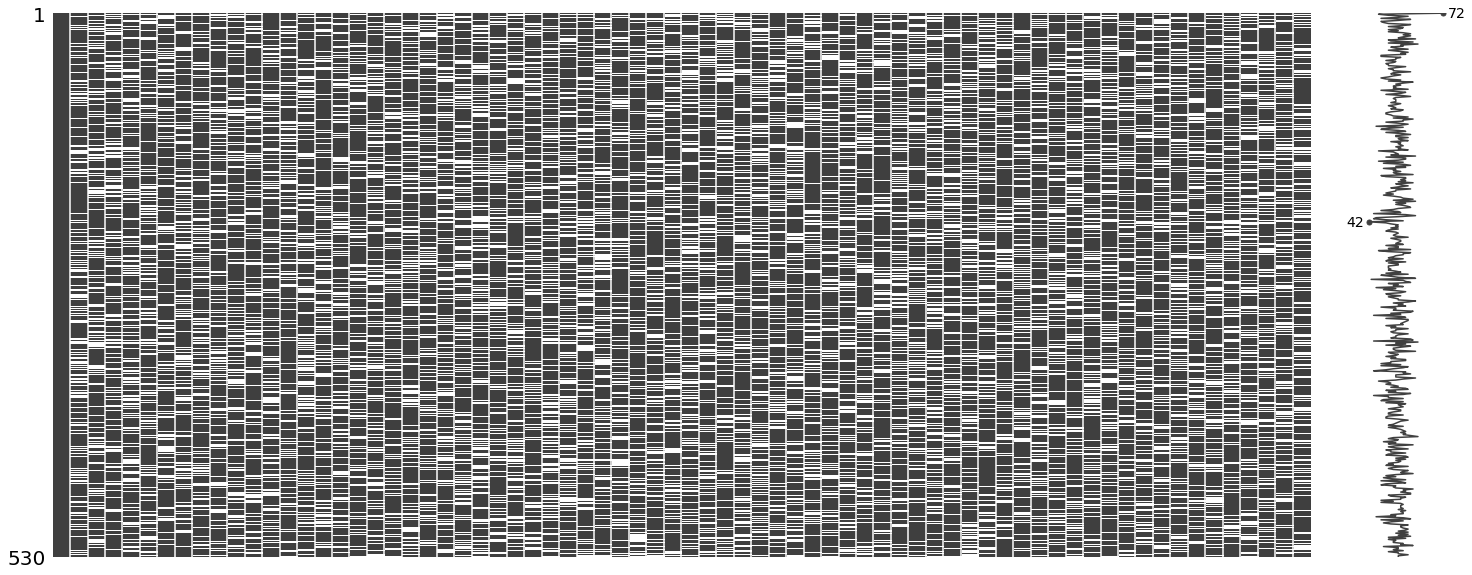

In [540]:
#visualizando missing values
import missingno as msno
msno.matrix(df)

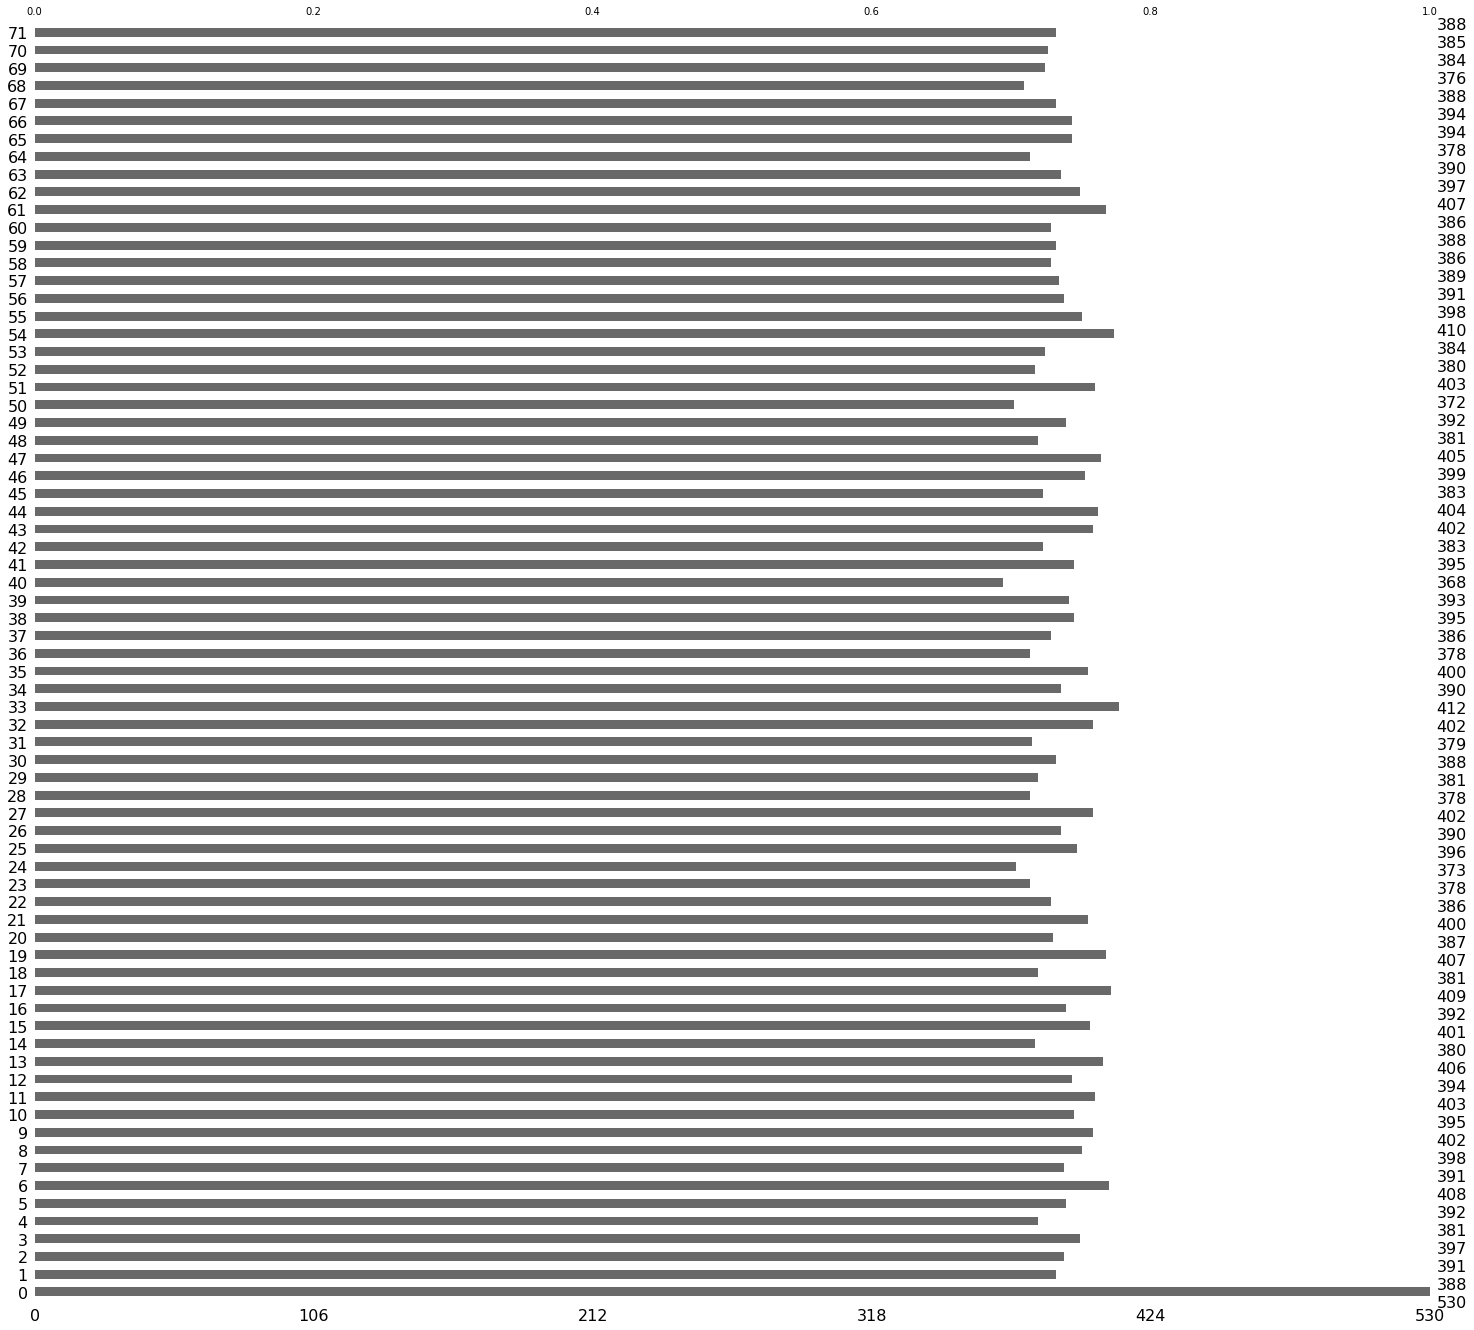

In [541]:
msno.bar(df)

In [542]:
missing_values = (df.isnull().sum()).sum()
missing_values

9840

In [543]:
missing_values = df.isnull().sum()

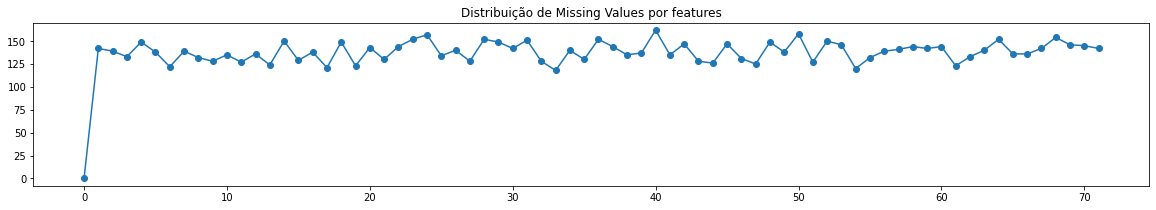

In [544]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,3))
plt.plot(missing_values,marker='o')


plt.title("Distribuição de Missing Values por features")
plt.show()

In [545]:
df.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,530.000000,388.000000,391.000000,397.000000,381.000000,392.000000,408.000000,391.000000,398.000000,402.000000,395.000000,403.000000,394.000000,406.000000,380.000000,401.000000,392.000000,409.000000,381.000000,407.000000,387.000000,400.000000,386.000000,378.000000,373.000000,396.000000,390.000000,402.000000,378.000000,381.000000,388.000000,379.000000,402.000000,412.000000,390.000000,400.000000,378.000000,386.000000,395.000000,393.000000,368.000000,395.000000,383.000000,402.000000,404.000000,383.000000,399.000000,405.000000,381.000000,392.000000,372.000000,403.000000,380.000000,384.000000,410.000000,398.000000,391.000000,389.000000,386.000000,388.000000,386.000000,407.000000,397.000000,390.000000,378.000000,394.000000,394.000000,388.000000,376.000000,384.000000,385.000000,388.000000
mean,0.069331,0.200570,0.085724,-73.135169,4.862836,0.566203,1.731595,0.630857,0.846861,0.500673,0.540394,0.475017,0.506826,0.478592,0.432713,0.446468,0.044986,0.159264,0.035512,4.531384,1.319022,0.944658,0.782578,0.637260,0.577980,0.550421,0.535264,0.519976,0.504604,0.492929,0.483178,0.468666,0.024083,0.064913,0.008118,3.645628,0.872976,0.626051,0.496976,0.383151,0.336311,0.312949,0.312935,0.305721,0.302643,0.278544,0.281924,0.270742,0.028961,0.064868,0.029495,4.160308,0.405212,0.237997,0.196673,0.153440,0.121418,0.114634,0.112524,0.113159,0.113184,0.111076,0.109281,0.109523,0.228551,74.195431,0.255710,153.538660,2.103723,0.409422,0.363411,0.943026
std,0.031252,0.122703,0.008587,7.424569,2.026122,1.001621,0.619257,0.451787,0.382034,0.308235,0.291670,0.286633,0.246363,0.219942,0.208349,0.200194,0.029038,0.108469,0.008894,1.575700,0.416395,0.269316,0.211265,0.146453,0.102561,0.091511,0.089616,0.081542,0.077091,0.071969,0.072246,0.071965,0.011225,0.033043,0.001536,1.818829,0.388933,0.258874,0.202573,0.149410,0.132404,0.139700,0.145480,0.152986,0.158541,0.159594,0.157256,0.169082,0.007598,0.023083,0.001603,0.532561,0.140139,0.086903,0.077431,0.062847,0.040767,0.037961,0.036782,0.042529,0.046516,0.049310,0.052781,0.061940,0.291100,14.453219,0.376046,30.940988,0.305308,0.345195,0.375911,0.648508
min,0.010201,0.038286,0.072043,-97.510495,0.051474,-2.277307,-0.604609,-1.143864,-0.237114,-0.444623,-0.895966,-0.451919,-0.294770,-0.186371,-0.275685,-0.129515,0.006918,0.017434,0.025297,1.682058,0.544490,0.426085,0.436355,0.375337,0.376085,0.329479,0.322254,0.327975,0.296855,0.337297,0.281625,0.315902,0.010684,0.018333,0.005696,1.103874,0.225593,0.107836,0.113009,0.057821,0.054569,0.050367,0.071779,0.055301,0.057608,0.049520,0.041973,0.033739,0.008712,0.015678,0.009090,1.908520,0.105014,0.066169,0.054015,0.034480,0.039299,0.024210,0.036153,0.032399,0.042171,0.038065,0.035496,0.035587,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,0.045049,0.106781,0.079523,-76.845586,3.335515,-0.142104,1.328466,0.357409,0.619595,0.301310,0.375777,0.301040,0.367468,0.357212,0.296032,0.307826,0.022667,0.065374,0.029985,3.413275,1.017934,0.730058,0.601599,0.526813,0.498042,0.483293,0.470566,0.464789,0.453098,0.438730,0.432111,0.419787,0.017365,0.042426,0.007258,2.376860,0.610741,0.441503,0.361797,0.280676,0.249046,0.221737,0.216704,0.202133,0.201823,0.176378,0.177529,0.170243,0.024747,0.050675,0.028965,3.764944,0.306713,0.167210,0.136746,0.106393,0.090777,0.085474,0.087385,0.082958,0.084387,0.077798,0.075566,0.072778,0.046469,64.000000,0.007126,132.000000,2.000000,0.173295,0.099424,0.505677
50%,0.065049,0.175288,0.083762,-72.555062,4.489410,0.527240,1.759319,0.604422,0.832817,0.522864,0.528445,0.452236,0.507940,0.493445,0.432957,0.459121,0.037532,0.126032,0.033556,4.343775,1.269576,0.934519,0.753744,0.613560,0.558687,0.540636,0.519738,0.514434,0.500663,0.484527,0.476160,0.462448,0.021384,0.056132,0.007832,3.302377,0.793542,0.586634,0.471871,0.3

In [546]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68.0,0.014937,136.0,2.0,0.245457,0.105065,0.405399
1,0.081374,0.272747,0.085733,NaN,NaN,NaN,0.163038,0.620251,0.458514,NaN,NaN,NaN,0.594871,0.734332,NaN,0.761508,0.066288,NaN,0.034438,3.480874,1.596532,0.943803,NaN,0.511229,0.498670,0.523039,NaN,NaN,0.483166,NaN,NaN,0.405593,0.013621,0.073041,0.010094,NaN,NaN,0.252972,NaN,0.205087,NaN,0.178009,0.144080,0.178703,0.146937,NaN,0.128202,NaN,NaN,0.066940,0.029483,3.963534,0.382360,0.168389,0.117525,0.098341,NaN,NaN,NaN,0.059457,0.053439,0.067684,0.070075,NaN,0.295031,70.0,0.276366,140.0,NaN,0.343547,0.276366,NaN


In [547]:
#Instalando o panda profile
#!pip install pandas-profiling
#from pandas_profiling import ProfileReport

#Imputação de dados


*   k-Nearest Neighbors (kNN) Imputation
*   Random Forest Imputation (MissForest)
*   mean
*   most_frequent
*   median







Library Missingpy

**missingpy** is a library for missing data imputation in Python. It has an API consistent with scikit-learn, so users already comfortable with that interface will find themselves in familiar terrain. Currently, the library supports k-Nearest Neighbors based imputation and Random Forest based imputation (MissForest) but we plan to add other imputation tools in the future so please stay tuned!

In [548]:
#installing
!pip install missingpy

# Criação da popoulação inicial

imputando os indivíduos

In [549]:
#!pip install -U scikit-learn

In [550]:
#!pip install sklearn
#import sklearn
#from sklearn import neighbors

In [551]:
import sklearn.neighbors._base
import sys

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [552]:
from sklearn.impute import SimpleImputer

In [553]:
#def knnImp(dataset_amputed):
#  from missingpy import KNNImputer
#  imputer_knn = KNNImputer(missing_values="NaN", n_neighbors=5, weights="uniform", 
#                 metric="masked_euclidean", row_max_missing=0.5, 
#                 col_max_missing=0.8, copy=True)
  
  #X_imputed_KNNI = imputer_knn.fit_transform(dataset_amputed)
  #return X_imputed_KNNI

In [554]:
from sklearn.impute import KNNImputer
def knnImp(dataset_amputed,neighbors):
  inputer_knn = KNNImputer(n_neighbors=neighbors)
  X_imputed_knn = inputer_knn.fit_transform(dataset_amputed)
  return X_imputed_knn

In [555]:
def rfImp(dataset_amputed):
  from missingpy import MissForest
  imputer_RFI = MissForest()
  X_imputed_RFI = imputer_RFI.fit_transform(dataset_amputed)
  return X_imputed_RFI

In [556]:
def meanImp(dataset_amputed):
  imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer_mean=imputer_mean.fit(dataset_amputed)
  X_imputed_mean = imputer_mean.transform(dataset_amputed)
  return X_imputed_mean

In [557]:
def mostFrequentImp(dataset_amputed):
  imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  imputer_most_frequent=imputer_most_frequent.fit(dataset_amputed)
  X_imputed_most_frequent=imputer_most_frequent.transform(dataset_amputed)
  return X_imputed_most_frequent

In [558]:
def medianImp(dataset_amputed):
  imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
  imputer_median=imputer_median.fit(df_median)
  X_imputed_median=imputer_median.transform(df_median)
  return X_imputed_median

Padronização dos dados

In [559]:
df_Mean = df
df_median = df
df_Most_frequent = df
df_kNN = df
df_RF = df

In [560]:
ind1 =  meanImp(df_Mean)
ind2 =  medianImp(df_median)
ind3 =  mostFrequentImp(df_Most_frequent)


In [561]:
ind4 = knnImp(df_kNN, 3)
ind5 = knnImp(df_kNN, 5)
ind6 = knnImp(df_kNN, 10)

In [562]:
#dataset_amputed - base já com valores ausentes
#imputation_type - list de métodos de iputação simples ['kNN', 'RF', 'mean', 'most_frequent', 'median']
#imputations = ['kNN', 'RF', 'mean', 'most_frequent', 'median']
#dfs = ['df_kNN', 'df_RF', 'df_Mean', 'df_Most_frequent', 'df_median']

#cópias do database aputudo para cada método no formação da pop. inicial









individuos = [ind1, ind2, ind3, ind4, ind5, ind6]


In [563]:
len(individuos)

6

Normmalização da população inicial

In [564]:
populationInitial = []
for i in range(len(individuos)):
  scaler = StandardScaler()
  populationInitial.append(scaler.fit_transform(individuos[i]))

In [565]:
populationInitial

[array([[-1.10787768e+00, -1.05774311e+00,  7.46777407e-01, ...,
         -5.58761401e-01, -8.07400189e-01, -9.70170790e-01],
        [ 3.85709262e-01,  6.88372280e-01,  1.22662999e-03, ...,
         -2.24489938e-01, -2.72039272e-01,  6.21068105e-15],
        [ 1.32001383e+00,  6.96192900e-01,  3.39109102e-14, ...,
         -9.45855529e-16, -5.20461073e-16, -8.76383262e-01],
        ...,
        [-1.09416947e+00, -6.88257382e-15, -1.42498540e+00, ...,
         -7.67128150e-01, -3.63390751e-01, -8.40976319e-01],
        [-4.82200136e-01,  3.58485207e-01,  1.38617001e+00, ...,
          4.69267329e-01, -5.62288827e-01,  5.64450711e-01],
        [ 1.23715799e-01, -5.70690199e-01, -7.03055496e-01, ...,
         -1.09763399e+00, -3.95646605e-01, -8.86616827e-01]]),
 array([[-1.10787768, -0.98752421,  0.81108194, ..., -0.45315029,
         -0.69185134, -0.88496561],
        [ 0.38570926,  0.74871909,  0.07059547, ..., -0.12316649,
         -0.16421797, -0.2111069 ],
        [ 1.32001383,  0.

# Função Fitness

Os indivíduos da população são avaliados no aprendizado multirrótulo.
Neste experimento, serão testados algorítmos que transformam o problema e algorítmos que adaptam o problema.

In [566]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def evaluation_binaryRelevance(core_algorithm, individual):
  if core_algorithm == 'svm':
    classifier_br = BinaryRelevance(
    classifier=SVC(C=50.0))#
    classifier_br.fit(individual, y_train)
    prediction_br = classifier_br.predict(X_test)

    F1 = f1_score(y_test, prediction_br, average='micro')
    ACC = accuracy_score(y_test, prediction_br)
    HL = hamming_loss(y_test, prediction_br)

  elif core_algorithm == 'randomForest':
    classifier = BinaryRelevance(classifier = RandomForestClassifier(),require_dense = [False, True])
    classifier.fit(individual, y_train)
    prediction_br_RFC=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_RFC, average='micro')
    ACC = accuracy_score(y_test, prediction_br_RFC)
    HL = hamming_loss(y_test, prediction_br_RFC)
  elif core_algorithm == '3nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=3))
    classifier.fit(individual, y_train)
    prediction_br_3knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_3knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_3knn)
    HL = hamming_loss(y_test, prediction_br_3knn)
  elif core_algorithm == '5nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier())
    classifier.fit(individual, y_train)
    prediction_br_5knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_5knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_5knn)
    HL = hamming_loss(y_test, prediction_br_5knn)
  elif core_algorithm == '10nn':
    classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=10))
    classifier.fit(individual, y_train)
    prediction_br_10knn=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_10knn, average='micro')
    ACC = accuracy_score(y_test, prediction_br_10knn)
    HL = hamming_loss(y_test, prediction_br_10knn) 
  elif core_algorithm == 'lr':
    from sklearn.linear_model import LogisticRegression
    classifier = BinaryRelevance(classifier = LogisticRegression())
    classifier.fit(individual, y_train)
    prediction_br_lr=classifier.predict(X_test)

    F1 = f1_score(y_test, prediction_br_lr, average='micro')
    ACC = accuracy_score(y_test, prediction_br_lr)
    HL = hamming_loss(y_test, prediction_br_lr)
  return  F1

Não executando Random Forest devido também ser um algorítmo que funciona como bagging

In [567]:
def fitness(populationInitial):
  acc = []
  populacao = []
  aval_lista_descrecente = []
  aval_lista_crescente = []
  indivuduos = {}
  accuracy = {}
  #population_atual = []
  #population_atual.append(populationAtual)
  print('tam_pop_atual: ',len(populationInitial))

  print('Avaliações com Binary Relevance\n')
  indexx = 0
  for i in range(len(populationInitial)):
    print('Individual - ',i)
    
    #F_svm,A_svm,H_svm = evaluation_binaryRelevance('svm', populationAtual[indexx])
    #F_RF,A_RF,H_RF = evaluation_binaryRelevance('randomForest', populationAtual[indexx])
    #F_3nn,A_3nn,H_3nn = evaluation_binaryRelevance('3nn', populationAtual[indexx])
    #F_5nn,A_5nn,H_5nn = evaluation_binaryRelevance('5nn', populationAtual[indexx])
    #F_10nn,A_10nn,H_10nn = evaluation_binaryRelevance('10nn', populationAtual[indexx])
    acc.append(evaluation_binaryRelevance('svm', populationInitial[indexx]))
    acc.append(evaluation_binaryRelevance('randomForest', populationInitial[indexx]))
    acc.append(evaluation_binaryRelevance('3nn', populationInitial[indexx]))
    acc.append(evaluation_binaryRelevance('5nn', populationInitial[indexx]))
    acc.append(evaluation_binaryRelevance('10nn', populationInitial[indexx]))
    #acc.append(evaluation_binaryRelevance('10nn', populationInitial[indexx]))
    
    #print(populationInitialScale[i])
    aval_lista_descrecente = sorted(acc, reverse=True)
    #print(aval_lista_descrecente)
    aval_lista_crescente = sorted(acc)
    #print(aval_lista_crescente)

    melhor = aval_lista_descrecente[0]
    pior = aval_lista_crescente[0]

    populacao.append([melhor, populationInitial[indexx]])

    indivuduos[i] = melhor
    indexx = indexx+1
    print('Pior:', pior, ' melhor:', melhor, ' escolhido: ', melhor)
    print('----------------------------------------------------')
    melhor = ''
    pior = ''
    aval_lista_descrecente = []
    aval_lista_crescente = []
    acc = []
  return populacao



In [568]:
populacao_inicial_avaliada = fitness(populationInitial)

tam_pop_atual:  6
Avaliações com Binary Relevance

Individual -  0
Pior: 0.6310679611650486  melhor: 0.6635071090047393  escolhido:  0.6635071090047393
----------------------------------------------------
Individual -  1
Pior: 0.6305418719211823  melhor: 0.7009345794392523  escolhido:  0.7009345794392523
----------------------------------------------------
Individual -  2
Pior: 0.600896860986547  melhor: 0.6756756756756757  escolhido:  0.6756756756756757
----------------------------------------------------
Individual -  3
Pior: 0.6063348416289593  melhor: 0.6990291262135923  escolhido:  0.6990291262135923
----------------------------------------------------
Individual -  4
Pior: 0.588235294117647  melhor: 0.679245283018868  escolhido:  0.679245283018868
----------------------------------------------------
Individual -  5
Pior: 0.6278026905829596  melhor: 0.6883720930232559  escolhido:  0.6883720930232559
----------------------------------------------------


In [569]:
def fitness_population(populationInitial):
  acc = []
  f1 = []
  populacao = []
  populacao.append(populationInitial[0])
  aval_lista_descrecente = []
  aval_lista_crescente = []
  indivuduos = {}
  accuracy = {}
  #population_atual = []
  #population_atual.append(populationAtual)
  print(len(populationInitial))

  print('Avaliações com Binary Relevance\n')
  indexx = 0
  for i in range(len(populationInitial)):
    print('Individual - ',i)
    ind_atual = populationInitial[indexx]
    #acc.append(evaluation_binaryRelevance('svm', ind_atual[1]))
    #acc.append(evaluation_binaryRelevance('randomForest', ind_atual[1]))
    #acc.append(evaluation_binaryRelevance('3nn', ind_atual[1]))
    #acc.append(evaluation_binaryRelevance('5nn', ind_atual[1]))
    #acc.append(evaluation_binaryRelevance('10nn', ind_atual[1]))

    f1.append(evaluation_binaryRelevance('svm', ind_atual[1]))
    f1.append(evaluation_binaryRelevance('randomForest', ind_atual[1]))
    f1.append(evaluation_binaryRelevance('3nn', ind_atual[1]))
    f1.append(evaluation_binaryRelevance('5nn', ind_atual[1]))
    f1.append(evaluation_binaryRelevance('10nn', ind_atual[1]))

    indexx = indexx+1
    #print(populationInitialScale[i])
    aval_lista_descrecente = sorted(f1, reverse=True)
    #print(aval_lista_descrecente)
    aval_lista_crescente = sorted(f1)
    #print(aval_lista_crescente)

    melhor = aval_lista_descrecente[0]
    pior = aval_lista_crescente[0]

    populacao.append([melhor, ind_atual[1]])
    indivuduos[i] = melhor
    
    print('Pior:', pior, ' melhor:', melhor, ' escolhido: ', melhor)
    print('----------------------------------------------------')
    melhor = ''
    pior = ''
    aval_lista_descrecente = []
    aval_lista_crescente = []
    #acc = []
    f1 =[]
  return populacao

In [570]:
populacao_inicial_avaliada

[[0.6635071090047393,
  array([[-1.10787768e+00, -1.05774311e+00,  7.46777407e-01, ...,
          -5.58761401e-01, -8.07400189e-01, -9.70170790e-01],
         [ 3.85709262e-01,  6.88372280e-01,  1.22662999e-03, ...,
          -2.24489938e-01, -2.72039272e-01,  6.21068105e-15],
         [ 1.32001383e+00,  6.96192900e-01,  3.39109102e-14, ...,
          -9.45855529e-16, -5.20461073e-16, -8.76383262e-01],
         ...,
         [-1.09416947e+00, -6.88257382e-15, -1.42498540e+00, ...,
          -7.67128150e-01, -3.63390751e-01, -8.40976319e-01],
         [-4.82200136e-01,  3.58485207e-01,  1.38617001e+00, ...,
           4.69267329e-01, -5.62288827e-01,  5.64450711e-01],
         [ 1.23715799e-01, -5.70690199e-01, -7.03055496e-01, ...,
          -1.09763399e+00, -3.95646605e-01, -8.86616827e-01]])],
 [0.7009345794392523,
  array([[-1.10787768, -0.98752421,  0.81108194, ..., -0.45315029,
          -0.69185134, -0.88496561],
         [ 0.38570926,  0.74871909,  0.07059547, ..., -0.12316649,


# Elitismo
O melhor individuo é passado para a proxima geracao - Elitismo

In [571]:
def elitismo(populacao_avaliada):
  #ordena a população passada de forma descrescente
  populacao_ordenada  = sorted(populacao_avaliada, key=lambda x: x[0], reverse=True)
  elitista = populacao_ordenada[0]
  return elitista

In [572]:
elitista = elitismo(populacao_inicial_avaliada)

In [573]:
elitista

[0.7009345794392523,
 array([[-1.10787768, -0.98752421,  0.81108194, ..., -0.45315029,
         -0.69185134, -0.88496561],
        [ 0.38570926,  0.74871909,  0.07059547, ..., -0.12316649,
         -0.16421797, -0.2111069 ],
        [ 1.32001383,  0.75649549, -0.1951545 , ..., -0.25892107,
         -0.27585813, -0.79194608],
        ...,
        [-1.09416947, -0.17552543, -1.34592872, ..., -0.65884435,
         -0.25425085, -0.75682907],
        [-0.48220014,  0.42069711,  1.44613134, ...,  0.56169205,
         -0.45027798,  0.63708938],
        [ 0.1237158 , -0.50322497, -0.62890267, ..., -0.98511084,
         -0.28604112, -0.80209584]])]

# Seleção

O processo de seleçãp é dado por torneio, sorteando dois pais

In [574]:
import random
def selecao(pop_atual):
  sorteio1 = random.choice(range(len(pop_atual)))
  #print(sorteio1)
  sorteio2 = random.choice(range(len(pop_atual)))
  #print(sorteio2)
  pai1 = pop_atual[sorteio1]
  pai2 = pop_atual[sorteio2]
  #print(pai1[0])
  #print(pai2[0])

  if(pai1[0] >= pai2[0]):
    return pai1
  else:
    return pai2

#Cruzamento

Cruzamento de n-points

In [575]:
#indeces com a posição do valores ausentes
index_vas = indexList

In [576]:
import numpy
ss = index_vas
final_list = numpy.array_split(ss,2);
final_list

[array([[416,  50],
        [334,  71],
        [367,  44],
        ...,
        [487,  35],
        [ 23,  40],
        [455,  22]]), array([[325,  14],
        [174,   3],
        [134,   4],
        ...,
        [490,  33],
        [294,  37],
        [524,  46]])]

In [577]:
len(ss), len(final_list[0]),len(final_list[1]) 

(11448, 5724, 5724)

In [578]:
#indices dos missing values
#indexList[0]
#for i in indexList:
#  df.iloc[indexList[0][0],indexList[0][1]] = np.nan

In [579]:
import numpy

def crossover(list_index_vas,n_points, new_population, tam_population):
  nova_populacao_com_crossover = []
  #elitista = new_population[0]
  #nova_populacao_com_crossover.append(elitista[1])

  while(len(nova_populacao_com_crossover)<tam_population):
    sorteio1 = random.choice(range(len(new_population)))
    #escolha dos pais que terão materiais trocados
    #print(sorteio1)
    sorteio2 = random.choice(range(len(new_population)))
    #print(sorteio2)
    while(sorteio1 == sorteio2):
      sorteio2 = random.choice(range(len(new_population)))
    pai1 = new_population[sorteio1]
    pai2 = new_population[sorteio2]

    #print(pai1[0])
    #print(pai2[0])
    #troca de material genético
    #mudando pra dataframe

    df_pai1 = pd.DataFrame(pai1[1])
    df_pai2 = pd.DataFrame(pai2[1])

    
    genes_all_pai1 = []

    genes_all_pai2 = []


    #recuperando os genes de cada pai
    for i in list_index_vas:
      genes_all_pai1.append(df_pai1.iloc[i[0],i[1]])
      genes_all_pai2.append(df_pai2.iloc[i[0],i[1]])
    #dividindo os genes de acordo com o n_points
    divide_genes_pai_1 = numpy.array_split(genes_all_pai1,n_points)
    divide_genes_pai_2 = numpy.array_split(genes_all_pai2,n_points)

    genes_0_pai1 = divide_genes_pai_1[0]
    genes_1_pai1 = divide_genes_pai_1[1]

    genes_0_pai2 = divide_genes_pai_2[0]
    genes_1_pai2 = divide_genes_pai_2[1]

    t1 = len(genes_1_pai1)
    t2 = len(genes_1_pai2)

    divide_list_index = numpy.array_split(list_index_vas,n_points)
    primeira_parte = divide_list_index[0]
    segunda_parte = divide_list_index[1]

    genes_parte_2_pai1 = genes_1_pai1.tolist()
    genes_parte_2_pai2 = genes_1_pai2.tolist()

    #Trocando genes dos pais
    index = 0
    for i in segunda_parte:

      #print('pai1: ',df_pai1.iloc[i[0].astype(int), i[1].astype(int)])
      #print('pai2: ',df_pai2.iloc[i[0].astype(int), i[1].astype(int)])
      #print('------------------------------------------------------')


      df_pai1.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai2[index]
      df_pai2.iloc[i[0].astype(int), i[1].astype(int)] = genes_1_pai1[index]

      #print('filho1: ',df_pai1.iloc[i[0].astype(int), i[1].astype(int)])
      #print('filho2: ',df_pai2.iloc[i[0].astype(int), i[1].astype(int)])
      #print('------------------------------------------------------')
      #print('Gene pai1: ',genes_1_pai1[index] )
      #print('Gene pai2: ',genes_1_pai2[index] )
      #print('--------------------------------------------------------')
      #print('--------------------------------------------------------')
      index = index +1
      
      

    filho1 = df_pai1
    filho2 = df_pai2
    nova_populacao_com_crossover.append(filho1.to_numpy())
    nova_populacao_com_crossover.append(filho2.to_numpy())

    

  

  #filho1, filho2,pai1[1],pai1[2]
  print('pop_cruzada',len(nova_populacao_com_crossover))
  return nova_populacao_com_crossover

In [580]:
#nova_populacao_recombinada = crossover(ss,2,atual,4)

# Mutação

In [581]:
def mutacao(dX_amputed,ind, list_missing_values=index_vas):
  import random
  #de numpy para pandas format
  ind = pd.DataFrame(ind)
  #serão selecionados x% de individuos da população e são trocadas todas as solucões
  #candidatas já imputadas por uma nova solução da pool de soluções
  #amount_inds_mutation = int(rate_mutation *  len(inds_pop))
  for i in list_missing_values:
    #criando um pool solutions de acordo com a o valor de x da lista de index
    lista_do_indice_atual = dX_amputed.iloc[:,i[1]]
    #removendo o indices NaN para criar a pool solutions só com soluções candatas não-nulas
    pool_solutions = [x for x in lista_do_indice_atual if pd.isnull(x) == False]
    
    
    #substituindo o gene do indivíduo por um dos genes da pool solutions
    #print('index: ', i[0],',', i[1])
    #print('antes: ',ind.iloc[i[0],i[1]])
    ind.iloc[i[0],i[1]] = random.choice(pool_solutions)
    #print('depois: ',ind.iloc[i[0],i[1]])
  return ind.to_numpy()


In [582]:
#ind = mutacao(df_amp)

In [583]:
def mutations(dX_amputed,population, rate_mutation):
  populacao_cruzada = population.copy()
  amount_inds_mutation = int(rate_mutation *  len(populacao_cruzada))
  i = 0
  while(i < amount_inds_mutation):
    ind_escolhido_pra_mutacao = populacao_cruzada.pop(i)
    ind_mutado = mutacao(dX_amputed, ind_escolhido_pra_mutacao)
    populacao_cruzada.append(ind_mutado)
    i=i+1
  return populacao_cruzada

In [584]:
populationInitial[0]

array([[-1.10787768e+00, -1.05774311e+00,  7.46777407e-01, ...,
        -5.58761401e-01, -8.07400189e-01, -9.70170790e-01],
       [ 3.85709262e-01,  6.88372280e-01,  1.22662999e-03, ...,
        -2.24489938e-01, -2.72039272e-01,  6.21068105e-15],
       [ 1.32001383e+00,  6.96192900e-01,  3.39109102e-14, ...,
        -9.45855529e-16, -5.20461073e-16, -8.76383262e-01],
       ...,
       [-1.09416947e+00, -6.88257382e-15, -1.42498540e+00, ...,
        -7.67128150e-01, -3.63390751e-01, -8.40976319e-01],
       [-4.82200136e-01,  3.58485207e-01,  1.38617001e+00, ...,
         4.69267329e-01, -5.62288827e-01,  5.64450711e-01],
       [ 1.23715799e-01, -5.70690199e-01, -7.03055496e-01, ...,
        -1.09763399e+00, -3.95646605e-01, -8.86616827e-01]])

In [585]:
a = populationInitial.pop(0)

In [586]:
a

array([[-1.10787768e+00, -1.05774311e+00,  7.46777407e-01, ...,
        -5.58761401e-01, -8.07400189e-01, -9.70170790e-01],
       [ 3.85709262e-01,  6.88372280e-01,  1.22662999e-03, ...,
        -2.24489938e-01, -2.72039272e-01,  6.21068105e-15],
       [ 1.32001383e+00,  6.96192900e-01,  3.39109102e-14, ...,
        -9.45855529e-16, -5.20461073e-16, -8.76383262e-01],
       ...,
       [-1.09416947e+00, -6.88257382e-15, -1.42498540e+00, ...,
        -7.67128150e-01, -3.63390751e-01, -8.40976319e-01],
       [-4.82200136e-01,  3.58485207e-01,  1.38617001e+00, ...,
         4.69267329e-01, -5.62288827e-01,  5.64450711e-01],
       [ 1.23715799e-01, -5.70690199e-01, -7.03055496e-01, ...,
        -1.09763399e+00, -3.95646605e-01, -8.86616827e-01]])

# Algoritmo Genético



1.   elitisimo: 1
2.   gerações: 6
3.   geracoes_sizes{6,12,18,24,30}
4.   cruzamento: n-points
5.   cruzamento: torneio



In [587]:
def nova_populacao(df_amp,individuo_elitista, pop_atual, tam_population,n_points, list_index_vas=index_vas):
  formacao_nova_populacao = []
  formacao_nova_populacao.append(individuo_elitista)
  while(len(formacao_nova_populacao)<= tam_population):
    formacao_nova_populacao.append(selecao(pop_atual))
  #pega a população selecionada para fazer a recombinação
  nova_populacao_combinada = crossover(list_index_vas,n_points, formacao_nova_populacao, tam_population)
  #20% dos individuos sofrem mutações
  #a nova populacao combinada é passada como parametro
  populacao_cruzada_e_mutada = mutations(df_amp,nova_populacao_combinada, 0.20)

  return populacao_cruzada_e_mutada

In [588]:
def main(gen_sizes):
  melhor = elitista
  otimizacao = []
  otimizacao.append(melhor)
  #populacao inicial
  populacao_inicial = populacao_inicial_avaliada
  for i in gen_sizes:
    print('tamanho da população atual',len(populacao_inicial))
    #Cria nova populacao
    n_pop = nova_populacao(df_amp, melhor, populacao_inicial, i,2)
    #avalia populacao formada
    
    populacao_atual_avaliada = fitness(n_pop)
    #print(n_pop[0])
    #passando o melhor elitista
    #print(melhor)
    populacao_inicial = []
    melhor_atual  = elitismo(populacao_atual_avaliada)
    if (melhor_atual[0]>melhor[0]):
      otimizacao.append(melhor_atual)
      #populacao_inicial.append(melhor_atual)
      melhor = melhor_atual
      print('Novo melhor:',melhor_atual[0])
    else:
      populacao_atual_avaliada.pop(len(populacao_atual_avaliada)-1)
      otimizacao.append(melhor)
      populacao_inicial.append(melhor)
      print('melhor anterior foi escolhido: ',melhor[0])
    populacao_inicial.extend(populacao_atual_avaliada)
    print(len(populacao_inicial))
    ##populancao anterior recebe a nova população avliada
    


  return otimizacao, len(n_pop)


# Running

In [589]:
gen_sizes = [8,10,12,14,16,18]#[10,20,40,20,10,5]
result,p = main(gen_sizes)
result

tamanho da população atual 6
pop_cruzada 8
tam_pop_atual:  8
Avaliações com Binary Relevance

Individual -  0
Pior: 0.588235294117647  melhor: 0.7009345794392523  escolhido:  0.7009345794392523
----------------------------------------------------
Individual -  1
Pior: 0.588235294117647  melhor: 0.6699029126213591  escolhido:  0.6699029126213591
----------------------------------------------------
Individual -  2
Pior: 0.588235294117647  melhor: 0.6981132075471698  escolhido:  0.6981132075471698
----------------------------------------------------
Individual -  3
Pior: 0.600896860986547  melhor: 0.673076923076923  escolhido:  0.673076923076923
----------------------------------------------------
Individual -  4
Pior: 0.6055045871559633  melhor: 0.6635071090047393  escolhido:  0.6635071090047393
----------------------------------------------------
Individual -  5
Pior: 0.6271186440677966  melhor: 0.6919431279620852  escolhido:  0.6919431279620852
-----------------------------------------

[[0.7009345794392523,
  array([[-1.10787768, -0.98752421,  0.81108194, ..., -0.45315029,
          -0.69185134, -0.88496561],
         [ 0.38570926,  0.74871909,  0.07059547, ..., -0.12316649,
          -0.16421797,  0.635845  ],
         [ 1.32001383,  0.75649549,  0.077901  , ...,  0.504136  ,
           1.270969  , -0.79194608],
         ...,
         [-1.09416947,  0.148414  , -1.34592872, ..., -0.65884435,
          -0.25425085, -0.75682907],
         [-0.48220014,  0.42069711,  1.44613134, ...,  0.56169205,
          -0.45027798,  0.63708938],
         [ 0.1237158 , -0.50322497, -0.62890267, ..., -0.98511084,
          -0.28604112, -0.80209584]])],
 [0.7009345794392523,
  array([[-1.10787768, -0.98752421,  0.81108194, ..., -0.45315029,
          -0.69185134, -0.88496561],
         [ 0.38570926,  0.74871909,  0.07059547, ..., -0.12316649,
          -0.16421797,  0.635845  ],
         [ 1.32001383,  0.75649549,  0.077901  , ...,  0.504136  ,
           1.270969  , -0.79194608],
   

In [590]:
p

18

In [591]:
dados = []
for i in result:
  dados.append(i[0])

In [592]:
dados

[0.7009345794392523,
 0.7009345794392523,
 0.7069767441860465,
 0.7230046948356808,
 0.7230046948356808,
 0.7230046948356808,
 0.7230046948356808]

In [593]:
geracoes = pd.DataFrame({'geracoes':dados})

In [594]:
geracoes

,geracoes
0,0.700935
1,0.700935
2,0.706977
3,0.723005
4,0.723005
5,0.723005
6,0.723005


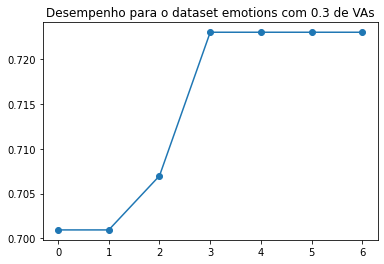

In [595]:
import matplotlib.pyplot as plt 
plt.figure()#figsize=(20,3)
plt.plot(geracoes,marker='o')
title = 'Desempenho para o dataset '+ dataset_name +' com '+ str(taxa_de_missing_values)+' de VAs'
plt.title(title)
plt.show()

###Teste isolado para avaliar o desempenho do dataset original e sem missing values e com outros classificadores

In [596]:
sc = StandardScaler()
sc = sc.fit_transform(X_train.toarray())
Arf= evaluation_binaryRelevance('randomForest', sc)
Asvm = evaluation_binaryRelevance('svm', sc)
print('SVM:           ',Asvm) 
print('Random Forest: ',Arf) 

SVM:            0.6434782608695652
Random Forest:  0.7136150234741784
